# Colorado Lottery Probability & Modeling

In [1]:
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
import pymc3 as pm
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

from statsmodels.tsa.api import VAR

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_multilabel_classification
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, GRU
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 400

In [2]:
df = pd.read_pickle('../data/co_lotto.pkl')
df2 = pd.read_pickle('../data/co_lotto_2.pkl')
lnums = pd.read_pickle(r'../data/co_lucky_num.pkl')

In [3]:
df2.set_index('draw_date', inplace=True)
df2.sort_index(inplace=True)

# Probabilities

## Jackpot Single Ticket

In [4]:
#'combinations' calculates the total different possible outcome combinations 
#or the odds of the event happening.
#Odds is the number of occurrences of a certain event expressed as a proportion of the number 
#of non-occurrences of that event.


def combinations(possible_numbers_drawn, total_balls_drawn):
    numerator = math.factorial(possible_numbers_drawn)   
    denominator = math.factorial(total_balls_drawn) * math.factorial(possible_numbers_drawn-total_balls_drawn) 
    odds = numerator / denominator
    return odds


#'one_ticket_probability' calculates the probability of winning with a single ticket
#probability is defined as the number of occurrences of a certain event expressed as a 
#proportion of all events that could occur.


def one_ticket_probability(numbers):
    total_outcomes = round(combinations(40, 6)) #odds
    successful_outcome = 1 / total_outcomes #isnt this the probability?
    probability_winning = (successful_outcome / total_outcomes) * 100
    print(f"Odds of you selecting all lottery number's correctly with a single ticket is 1 in {total_outcomes}!")
    print(f"The probability of you winning the jackpot is {successful_outcome:.20f}%!")
    return probability_winning
    
test_ticket = [1,4,32,38,5,18] #insignificant random numbers
one_ticket_probability(test_ticket)

# code help from: https://stackoverflow.com/questions/658763/how-to-suppress-scientific-notation-when-printing-float-values

Odds of you selecting all lottery number's correctly with a single ticket is 1 in 3838380!
The probability of you winning the jackpot is 0.00000026052657631605%!


6.787409696696262e-12

## Jackpot with Multiple tickets

In [5]:
def multi_ticket_prob(n_tickets_played):
    
    total_outcomes = combinations(40, 6)
    
    successful_outcome = n_tickets_played / total_outcomes
    
    odds_n_tickets = round(total_outcomes / n_tickets_played) 
    
    probability_n_tickets = 1 / odds_n_tickets
    
    print(f"The odds of you winning the jackpot with {n_tickets_played} tickets is 1 in {odds_n_tickets}!")
    print(f"The probability of you winning the jackpot with {n_tickets_played} tickets is {probability_n_tickets:.20f}%!")
    print(" ")

In [6]:
ticket_quantity = [2, 10, 100, 10000, 1000000, 6787409]
for tickets in ticket_quantity:
    multi_ticket_prob(tickets)

The odds of you winning the jackpot with 2 tickets is 1 in 1919190!
The probability of you winning the jackpot with 2 tickets is 0.00000052105315263210%!
 
The odds of you winning the jackpot with 10 tickets is 1 in 383838!
The probability of you winning the jackpot with 10 tickets is 0.00000260526576316050%!
 
The odds of you winning the jackpot with 100 tickets is 1 in 38384!
The probability of you winning the jackpot with 100 tickets is 0.00002605252188411838%!
 
The odds of you winning the jackpot with 10000 tickets is 1 in 384!
The probability of you winning the jackpot with 10000 tickets is 0.00260416666666666652%!
 
The odds of you winning the jackpot with 1000000 tickets is 1 in 4!
The probability of you winning the jackpot with 1000000 tickets is 0.25000000000000000000%!
 
The odds of you winning the jackpot with 6787409 tickets is 1 in 1!
The probability of you winning the jackpot with 6787409 tickets is 1.00000000000000000000%!
 


## Match 3/4/5 Single Ticket
https://owlcation.com/stem/How-to-Calculate-Lottery-Probability

|Winning Combination | Odds of Winning |
|--------------------|-----------------|
|Match 6             | 1 in 3,838,380  |
|Match 5             | 1 in 18,816     |
|Match 4             | 1 in 456        |
|Match 3             | 1 in 32         |

First, we need to find the number of way to choose x winning numbers from the set and multiply it by the number of ways to choose the losing numbers for the remaining 6-x numbers. Consider the number of ways to choose x winning numbers. Because there are only 6 possible winning numbers, in essence, we are only choosing x from a pool of 6. And so, because order does not matter, we get C(6, x).

Next, we consider the number of ways to choose the remaining 6-x balls from the pool of losing numbers. Because 6 are winning numbers, we have 40 - 6 = 34 balls to choose the losing numbers from. So, the number of possibilities for choosing a losing ball can be obtained from C(34, 6 - x). Again, order does not matter here.

So, in order to calculate the probability of winning with x matching numbers out of a possible 6, we need to divide the outcome from the previous two paragraphs by the total number of possibilities to win with all 6 matching numbers. We get:

numerator = C(k,x) * C(n-k, k-x)
denominator = C(n,k)

k = 6, total number of balls in the winning combination for the jackpot prize/
n = 40, total number of balls in the set/
x = total numbers of balls matching the winning set of numbers/

combinations(possible_numbers_drawn, total_balls_drawn)

numerator = C(6,x) * C(39,6-x)
denominator = C(40,6)

numerator / denominator

In [7]:
def other_odds(n,k,x):
    n_k = n-k
    k_x = k-x
    numerator = (combinations(k, x)) * (combinations(n_k,k_x))
    denominator = combinations(n,k)
    probability = numerator / denominator
    odds = 1 / probability
    
    print(f"The odds of selecting {x} numbers correctly with one ticket is 1 in {odds}!")
    print(f"The probability of selecting {x} numbers correctly with one ticket is {probability:.20f}%!")

In [8]:
other_odds(40,6,5)

The odds of selecting 5 numbers correctly with one ticket is 1 in 18815.58823529412!
The probability of selecting 5 numbers correctly with one ticket is 0.00005314742156847420%!


In [9]:
other_odds(40,6,4)

The odds of selecting 4 numbers correctly with one ticket is 1 in 456.13547237076654!
The probability of selecting 4 numbers correctly with one ticket is 0.00219233113969956057%!


In [10]:
other_odds(40,6,3)

The odds of selecting 3 numbers correctly with one ticket is 1 in 32.07202540106952!
The probability of selecting 3 numbers correctly with one ticket is 0.03117982065350486526%!


In [11]:
# k = 6, total number of balls in the winning combination for the jackpot prize 
# n = 40, total number of balls in the set 
# x = total numbers of balls matching the winning set of numbers.

# ( k!/ x!(k-x)! ) * (n-k)! / ( (n-k)-(k-x) )! (k-x)!)

def num_combos(n,k,x):
    n_k = n-k
    k_x = k-x
    n_kminus = n_k-k_x
    
    numerator = math.factorial(k)
    denominator = math.factorial(x) * math.factorial(k_x)
    a = numerator/ denominator
    
    numertor2= math.factorial(n_k)
    denominator2= math.factorial(n_kminus) * math.factorial(k_x)
    b = numertor2/denominator2
    
    combo = a*b

    return combo

In [12]:
num_combos(40,6,6)

1.0

In [13]:
num_combos(40,6,5) 
#there are 204 different ways to match 5 of 6 lottery numbers

204.0

In [14]:
num_combos(40,6,4)
#there are 8415 different ways to match 4 of 6 lottery numbers

8415.0

In [15]:
num_combos(40,6,3)
#there are 119680 different ways to match 3 of 6 lottery numbers

119680.0

In [16]:
#if a ticket has the numbers 1, 2, 3, 4, 5, and 6, 
#it wins as long as all the numbers 1 through 6 are drawn, 
#no matter what order they come out in. 
#Accordingly, given any set of 6 numbers, there are 
#6 × 5 × 4 × 3 × 2 × 1 = 6!(factorial) or 720 orders in which they could be drawn. 

def possible_orders(num_drawn):
    return 1 if (num_drawn==1 or num_drawn==0) else num_drawn * math.factorial(num_drawn - 1); 

possible_orders(6)

720

## Probaibility deducting number combinations of previously drawn
While researching one idea that kept being expressed was never to choose a number combination that had been previously drawn. The logic behind this is that once a combination is pulled it is less likely to be drawn again in the future than other combinations. Mathmatically this doesnt make logical sense to me as each drawing is independant of previous drawings but let's still explore this for fun. 

In [17]:
#https://www.vitoshacademy.com/python-permutations-and-combinations-made-easy-with-itertools/
# I WISH I WOULD HAVE KNOWN ABOUT THIS BEFORE DOING ALL THE WORK ABOVE! :D

In [18]:
lottery_numbers = list(range(1,41))
combination = itertools.combinations(lottery_numbers, 6)
print(list(combination)[:10])

[(1, 2, 3, 4, 5, 6), (1, 2, 3, 4, 5, 7), (1, 2, 3, 4, 5, 8), (1, 2, 3, 4, 5, 9), (1, 2, 3, 4, 5, 10), (1, 2, 3, 4, 5, 11), (1, 2, 3, 4, 5, 12), (1, 2, 3, 4, 5, 13), (1, 2, 3, 4, 5, 14), (1, 2, 3, 4, 5, 15)]


In [19]:
def combos_with_deductions(lottery_numbers, previous_combo_count, balls_drawn):
    lottery_combinations = itertools.combinations(lottery_numbers, balls_drawn)
    combination_w_deductions = (len(list(lottery_combinations))) - previous_combo_count
    return combination_w_deductions

In [20]:
df["winning_numbers"].value_counts()
#'1,8,9,21,35,39' and '4,6,16,25,28,41' combinations have been chosen twice so this theory
# is already proven to be incorrect 2/3227

4   6   16   25   28   41      2
1   8   9   21   35   39       2
3   11   13   19   33   42     1
4   14   15   22   33   41     1
16   23   27   29   32   34    1
                              ..
4   16   20   25   29   33     1
3   4   14   20   27   37      1
6   9   13   18   34   39      1
9   11   15   19   39   40     1
5   14   17   19   32   39     1
Name: winning_numbers, Length: 3237, dtype: int64

In [21]:
lottery_numbers = list(range(1,41))
previous_combo_count = 3237
balls_drawn = 6
combos_with_deductions(lottery_numbers, previous_combo_count, balls_drawn)

3835143

In [22]:
def one_ticket_probability_def(numbers):
    lottery_numbers = list(range(1,41))
    total_outcomes = round(combos_with_deductions(lottery_numbers, 3237, 6)) #odds
    successful_outcome = 1 / total_outcomes 
    print(f"Odds of you selecting all lottery number's correctly with a single ticket is 1 in {total_outcomes}!")
    print(f"The probability of you winning the jackpot is {successful_outcome:.20f}%!")
    
test_ticket = [1,4,32,38,5,18] #insignificant random numbers
one_ticket_probability_def(test_ticket)

#code help from #https://stackoverflow.com/questions/658763/how-to-suppress-scientific-notation-when-printing-float-values

Odds of you selecting all lottery number's correctly with a single ticket is 1 in 3835143!
The probability of you winning the jackpot is 0.00000026074647020985%!


In [23]:
one_ticket_probability(test_ticket)

Odds of you selecting all lottery number's correctly with a single ticket is 1 in 3838380!
The probability of you winning the jackpot is 0.00000026052657631605%!


6.787409696696262e-12

In [24]:
difference = 0.00000026074647020985 - 0.00000026052657631605
print(f'When you do not select past drawn numbers you are {difference:.17%} more likely to win')

When you do not select past drawn numbers you are 0.00000002198938938% more likely to win


## Jackpot Over Time

In [25]:
#The probability of a jackpot win after 1 ticket/1 week is:
prob = 1 / (combinations(40,6))
print(f'{prob:.20%}')

0.00002605265763160500%


In [26]:
#Probability of NO jackpot win after 1 ticket/2 weeks is:
1 - prob

0.9999997394734237

In [27]:
#Probability of NO jackpot win after 1 ticket/50 years (2600 weeks) is:
no_50_year = (1 - (prob) ) ** 2600
no_50_year

0.9993228601760686

In [28]:
#Probability of a jackpot win buying 1 tickets per week for 50 years (2600 weeks) is:
1 - no_50_year

0.0006771398239313609

## PYMC3: liklihood that the ball #34 will be drawn
12.04-lesson-pymc-bayesian-regression

In [29]:
def beta_stats(a, b):
    mean_ = a / (a + b)
    var_ = a*b / ((a + b)**2 * (a + b + 1))
    return mean_, var_

In [30]:
#want to be .025 or 1/40
#we know that 34 is the most frequent ball selected
beta_stats(1 , 40)

(0.024390243902439025, 0.0005665561882099657)

In [31]:
beta_stats(0,1)

(0.0, 0.0)

In [32]:
# Priors:
# N ~ Poi(40)
# p ~ Beta(1, 40) 

# Likelihood
# X ~ Binomial(Number of balls, probability of 34)

In [33]:
with pm.Model() as m:
    # Priors
    N = pm.Poisson("N", 40)
    p = pm.Beta("p", 1, 40)
    # Likelihood
    X = pm.Binomial("X", N, p, observed=df["ball_1"])
    # execute
    trace = pm.sample(10000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [N]
>NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 38 seconds.
The acceptance probability does not match the target. It is 0.9224286288491872, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6160188219680851, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.626418444234193, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


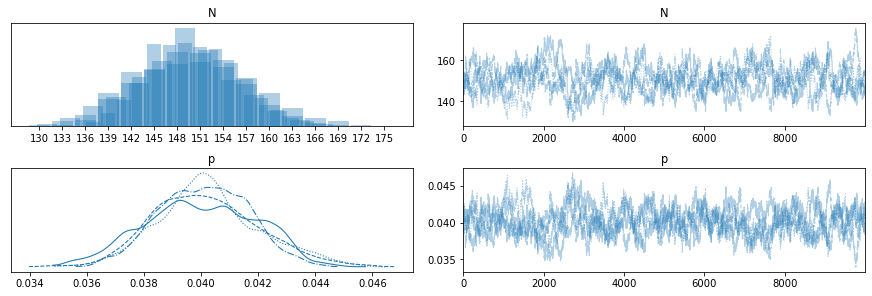

In [34]:
with m:
    pm.traceplot(trace);

In [35]:
# Expected mean that the number will be 34
np.mean(trace["p"])

0.040132551946749626

In [36]:
mean_34 = trace["N"]*trace["p"]

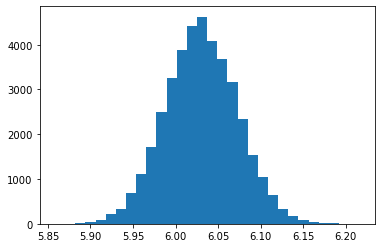

In [37]:
plt.hist(mean_34, bins=30);

# Bensford Law
7.07-lesson-benfords-law

In [38]:
df.head()

,draw_date,draw_year,draw_month,draw_day,winning_numbers_list,winning_numbers,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6,ball_1_int,ball_2_int,ball_3_int,ball_4_int,ball_5_int,ball_6_int,odd_even,odd_even_0,odd_even_1,odd_even_2,odd_even_3,odd_even_4,odd_even_5,odd_even_6,high_low,high_low_0,high_low_1,high_low_2,high_low_3,high_low_4,high_low_5,high_low_6,IQR,IQR_0,IQR_1,IQR_2,IQR_3,IQR_4,IQR_5,IQR_6,delta_1,delta_2,delta_3,delta_4,delta_5,jackpot,jackpot_cash_value,jackpot_co_winners,match_5_prize,match_5_co_winners,match_4_prize,match_4_co_winners,match_3_prize,match_3_co_winners,match_5_2x_prize,match_5_2x_winners,match_5_3x_prize,match_5_3x_winners,match_5_4x_prize,match_5_4x_winners,match_5_5x_prize,match_5_5x_winners,match_4_2x_prize,match_4_2x_winners,match_4_3x_prize,match_4_3x_winners,match_4_4x_prize,match_4_4x_winners,match_4_5x_prize,match_4_5x_winners,match_3_2x_prize,match_3_2x_winners,match_3_3x_prize,match_3_3x_winners,match_3_4x_prize,match_3_4x_winners,match_3_5x_prize,match_3_5x_winners
0,2020-12-02,2020,12,02,[22 27 28 29 33 36],22 27 28 29 33 36,22,27,28,29,33,36,22,27,28,29,33,36,3,0,0,0,1,0,0,0,6,0,0,0,0,0,0,1,2,0,0,1,0,0,0,0,5,1,1,4,3,11085298.0,5542649.0,0,0,0,0,0,0,0,500,6,750,4,1000,1,1250,1,50,293,75,165,100,63,125,63,6,4468,9,2746,12,913,15,903
1,2020-11-28,2020,11,28,[1 5 23 25 29 40],1 5 23 25 29 40,1,5,23,25,29,40,1,5,23,25,29,40,5,0,0,0,0,0,1,0,4,0,0,0,0,1,0,0,3,0,0,0,1,0,0,0,4,18,2,4,11,10781834.0,5390917.0,0,0,0,0,0,0,0,500,7,750,4,1000,2,1250,1,50,289,75,185,100,60,125,71,6,4534,9,2690,12,878,15,984
2,2020-11-25,2020,11,25,[3 21 22 23 30 37],3 21 22 23 30 37,3,21,22,23,30,37,3,21,22,23,30,37,4,0,0,0,0,1,0,0,5,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,18,1,1,7,7,10500925.0,5250462.0,0,0,0,0,0,0,0,500,8,750,3,1000,1,1250,1,50,328,75,177,100,71,125,74,6,4610,9,2825,12,931,15,910
3,2020-11-21,2020,11,21,[1 13 18 25 37 40],1 13 18 25 37 40,1,13,18,25,37,40,1,13,18,25,37,40,4,0,0,0,0,1,0,0,3,0,0,0,1,0,0,0,3,0,0,0,1,0,0,0,12,5,7,12,3,10193214.0,5096607.0,0,0,0,0,0,0,0,500,3,750,4,1000,1,1250,1,50,338,75,177,100,69,125,63,6,4533,9,2765,12,907,15,876
4,2020-11-18,2020,11,18,[4 7 9 14 15 18],4 7 9 14 15 18,4,7,9,14,15,18,4,7,9,14,15,18,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,1,0,0,0,3,2,5,1,3,9889874.0,4944937.0,0,0,0,0,0,0,0,500,11,750,3,1000,3,1250,1,50,344,75,192,100,66,125,68,6,4844,9,2821,12,895,15,966


In [39]:
def first_digit(amount):
    return int(str(amount)[0])
df['FIRST_DIGIT'] = df['winning_numbers'].map(first_digit)
df['FIRST_DIGIT_1'] = df['ball_1_int'].map(first_digit)
df['FIRST_DIGIT_2'] = df['ball_2_int'].map(first_digit)
df['FIRST_DIGIT_3'] = df['ball_3_int'].map(first_digit)
df['FIRST_DIGIT_4'] = df['ball_4_int'].map(first_digit)
df['FIRST_DIGIT_5'] = df['ball_5_int'].map(first_digit)
df['FIRST_DIGIT_6'] = df['ball_6_int'].map(first_digit)

In [40]:
actual_percentages = df['FIRST_DIGIT'].value_counts(normalize=True).sort_index()
actual_percentages_1 = df['FIRST_DIGIT_1'].value_counts(normalize=True).sort_index()
actual_percentages_2 = df['FIRST_DIGIT_2'].value_counts(normalize=True).sort_index()
actual_percentages_3 = df['FIRST_DIGIT_3'].value_counts(normalize=True).sort_index()
actual_percentages_4 = df['FIRST_DIGIT_4'].value_counts(normalize=True).sort_index()
actual_percentages_5 = df['FIRST_DIGIT_5'].value_counts(normalize=True).sort_index()
actual_percentages_6 = df['FIRST_DIGIT_6'].value_counts(normalize=True).sort_index()

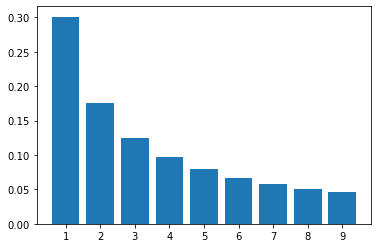

In [41]:
digits = list(range(1, 10))
benford_percentages = [np.log10(1 + 1 / d) for d in digits]
plt.bar(digits, benford_percentages)
plt.xticks(digits);

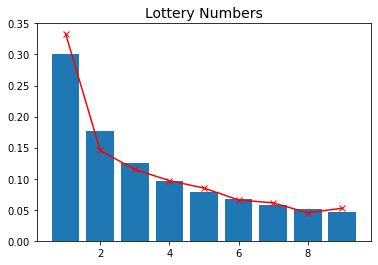

In [42]:
plt.bar(digits, benford_percentages)
plt.plot(digits, actual_percentages_1, color='r', marker='x')
plt.title('Lottery Numbers', size = 14);

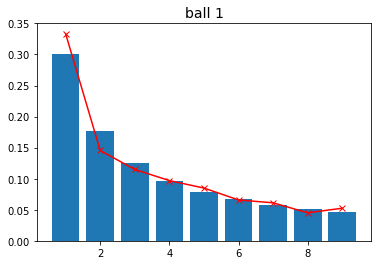

In [43]:
plt.bar(digits, benford_percentages)
plt.plot(digits, actual_percentages_1, color='r', marker='x')
plt.title('ball 1', size = 14);

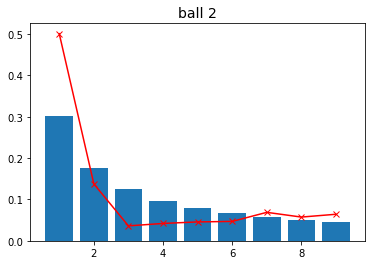

In [44]:
plt.bar(digits, benford_percentages)
plt.plot(digits, actual_percentages_2, color='r', marker='x');
plt.title('ball 2', size = 14);

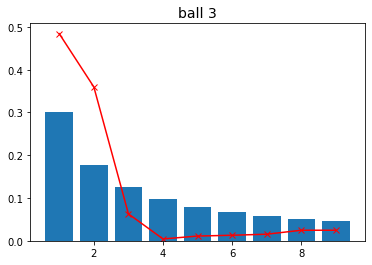

In [45]:
plt.bar(digits, benford_percentages)
plt.plot(digits, actual_percentages_3, color='r', marker='x');
plt.title('ball 3', size = 14);

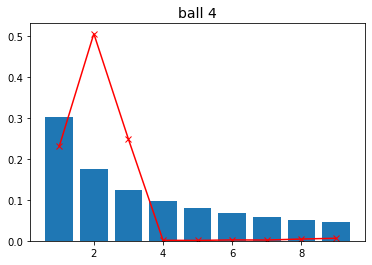

In [46]:
plt.bar(digits, benford_percentages)
plt.plot(digits, actual_percentages_4, color='r', marker='x');
plt.title('ball 4', size = 14);

In [47]:
df['FIRST_DIGIT_5'].value_counts()

3    1822
2    1089
1     178
4     145
9       4
7       1
Name: FIRST_DIGIT_5, dtype: int64

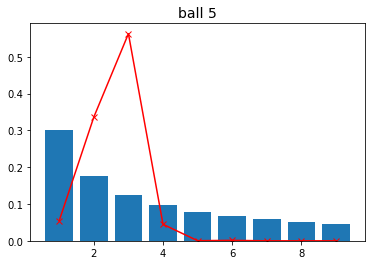

In [48]:
actual_percentages_5 = np.array(actual_percentages_5)
actual_percentages_5.resize((9,))
plt.bar(digits, benford_percentages)
plt.plot(digits, actual_percentages_5, color='r', marker='x');
plt.title('ball 5', size = 14);

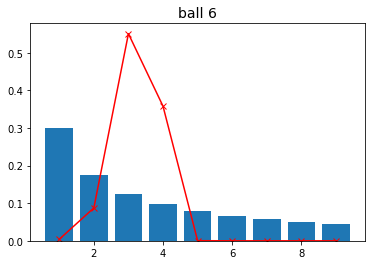

In [49]:
actual_percentages_6 = np.array(actual_percentages_6)
actual_percentages_6.resize((9,))
plt.bar(digits, benford_percentages)
plt.plot(digits, actual_percentages_6, color='r', marker='x');
plt.title('ball 6', size = 14);

## Seperating data frames for modeling

In [50]:
#df = normal df
#df2 = date as index
#lnums = lucky numbers

df = df[['draw_date','draw_year','draw_month','draw_day',
         'winning_numbers_list', 'winning_numbers',
         'ball_1', 'ball_2','ball_3','ball_4', 'ball_5', 'ball_6', 
         'ball_1_int', 'ball_2_int','ball_3_int','ball_4_int', 'ball_5_int', 'ball_6_int',
         'odd_even','odd_even_0','odd_even_1','odd_even_2','odd_even_3','odd_even_4','odd_even_5','odd_even_6',
         'high_low','high_low_0','high_low_1','high_low_2','high_low_3','high_low_4','high_low_5','high_low_6',
         'IQR', 'IQR_0','IQR_1','IQR_2','IQR_3','IQR_4','IQR_5','IQR_6',
         'delta_1', 'delta_2', 'delta_3', 'delta_4', 'delta_5',
         'jackpot', 'jackpot_cash_value', 'jackpot_co_winners',
         'match_5_prize','match_5_co_winners', 
         'match_4_prize', 'match_4_co_winners',
         'match_3_prize', 'match_3_co_winners', 
         'match_5_2x_prize', 'match_5_2x_winners', 
         'match_5_3x_prize', 'match_5_3x_winners',
         'match_5_4x_prize', 'match_5_4x_winners', 
         'match_5_5x_prize','match_5_5x_winners', 
         'match_4_2x_prize', 'match_4_2x_winners',
         'match_4_3x_prize', 'match_4_3x_winners', 
         'match_4_4x_prize','match_4_4x_winners', 
         'match_4_5x_prize', 'match_4_5x_winners',
         'match_3_2x_prize', 'match_3_2x_winners', 
         'match_3_3x_prize','match_3_3x_winners', 
         'match_3_4x_prize', 'match_3_4x_winners',
         'match_3_5x_prize', 'match_3_5x_winners',
        ]]

df3 = df2[['ball_1_int', 'ball_2_int','ball_3_int','ball_4_int', 'ball_5_int', 'ball_6_int',
         'odd_even','odd_even_0','odd_even_1','odd_even_2','odd_even_3','odd_even_4','odd_even_5','odd_even_6',
        'high_low','high_low_0','high_low_1','high_low_2','high_low_3','high_low_4','high_low_5','high_low_6',
         'IQR', 'IQR_0','IQR_1','IQR_2','IQR_3','IQR_4','IQR_5','IQR_6',
         'jackpot', 'jackpot_cash_value', 'jackpot_co_winners',
         'match_5_prize','match_5_co_winners', 
         'match_4_prize', 'match_4_co_winners',
         'match_3_prize', 'match_3_co_winners', 
         'match_5_2x_prize', 'match_5_2x_winners', 
         'match_5_3x_prize', 'match_5_3x_winners',
         'match_5_4x_prize', 'match_5_4x_winners', 
         'match_5_5x_prize','match_5_5x_winners', 
         'match_4_2x_prize', 'match_4_2x_winners',
         'match_4_3x_prize', 'match_4_3x_winners', 
         'match_4_4x_prize','match_4_4x_winners', 
         'match_4_5x_prize', 'match_4_5x_winners',
         'match_3_2x_prize', 'match_3_2x_winners', 
         'match_3_3x_prize','match_3_3x_winners', 
         'match_3_4x_prize', 'match_3_4x_winners',
         'match_3_5x_prize', 'match_3_5x_winners',
        ]]

### Time Seriese

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df3.drop(columns = 'ball_1_int'),
                                                    df3['ball_1_int'],
                                                    test_size = 0.2,
                                                    shuffle = False)

In [52]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Confirm.
X_train.head()

,const,ball_2_int,ball_3_int,ball_4_int,ball_5_int,ball_6_int,odd_even,odd_even_0,odd_even_1,odd_even_2,odd_even_3,odd_even_4,odd_even_5,odd_even_6,high_low,high_low_0,high_low_1,high_low_2,high_low_3,high_low_4,high_low_5,high_low_6,IQR,IQR_0,IQR_1,IQR_2,IQR_3,IQR_4,IQR_5,IQR_6,jackpot,jackpot_cash_value,jackpot_co_winners,match_5_prize,match_5_co_winners,match_4_prize,match_4_co_winners,match_3_prize,match_3_co_winners,match_5_2x_prize,match_5_2x_winners,match_5_3x_prize,match_5_3x_winners,match_5_4x_prize,match_5_4x_winners,match_5_5x_prize,match_5_5x_winners,match_4_2x_prize,match_4_2x_winners,match_4_3x_prize,match_4_3x_winners,match_4_4x_prize,match_4_4x_winners,match_4_5x_prize,match_4_5x_winners,match_3_2x_prize,match_3_2x_winners,match_3_3x_prize,match_3_3x_winners,match_3_4x_prize,match_3_4x_winners,match_3_5x_prize,match_3_5x_winners
draw_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1989-01-28,1.0,22,28,30,31,40,1,0,1,0,0,0,0,0,5,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,3201442.25,1573434.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1989-02-04,1.0,11,29,30,39,40,4,0,0,0,0,1,0,0,4,0,0,0,0,1,0,0,4,0,0,0,0,1,0,0,3201442.25,1573434.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1989-02-11,1.0,12,27,30,34,39,2,0,0,1,0,0,0,0,4,0,0,0,0,1,0,0,3,0,0,0,1,0,0,0,3201442.25,1573434.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1989-02-18,1.0,17,19,31,33,39,5,0,0,0,0,0,1,0,3,0,0,0,1,0,0,0,4,0,0,0,0,1,0,0,3201442.25,1573434.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1989-02-25,1.0,9,24,25,26,28,2,0,0,1,0,0,0,0,4,0,0,0,0,1,0,0,2,0,0,1,0,0,0,0,3201442.25,1573434.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index] 

In [54]:
lm = sm.OLS(y_train, X_train)
lm_results = lm.fit()
print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:             ball_1_int   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     83.88
Date:                Fri, 11 Dec 2020   Prob (F-statistic):               0.00
Time:                        07:26:46   Log-Likelihood:                -6747.3
No. Observations:                2591   AIC:                         1.356e+04
Df Residuals:                    2558   BIC:                         1.375e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2262      0

In [55]:
lm_results.predict(X_test)

draw_date
2014-09-17     3.354723
2014-09-20     2.991314
2014-09-24     6.972175
2014-09-27     3.347692
2014-10-01     8.596988
                ...    
2020-11-18     4.578180
2020-11-21     7.321802
2020-11-25    10.190770
2020-11-28     3.977908
2020-12-02    24.348364
Length: 648, dtype: float64

In [56]:
r2_score(y_test, lm_results.predict(X_test))

0.5173146123108439

In [57]:
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

3.345077783650777

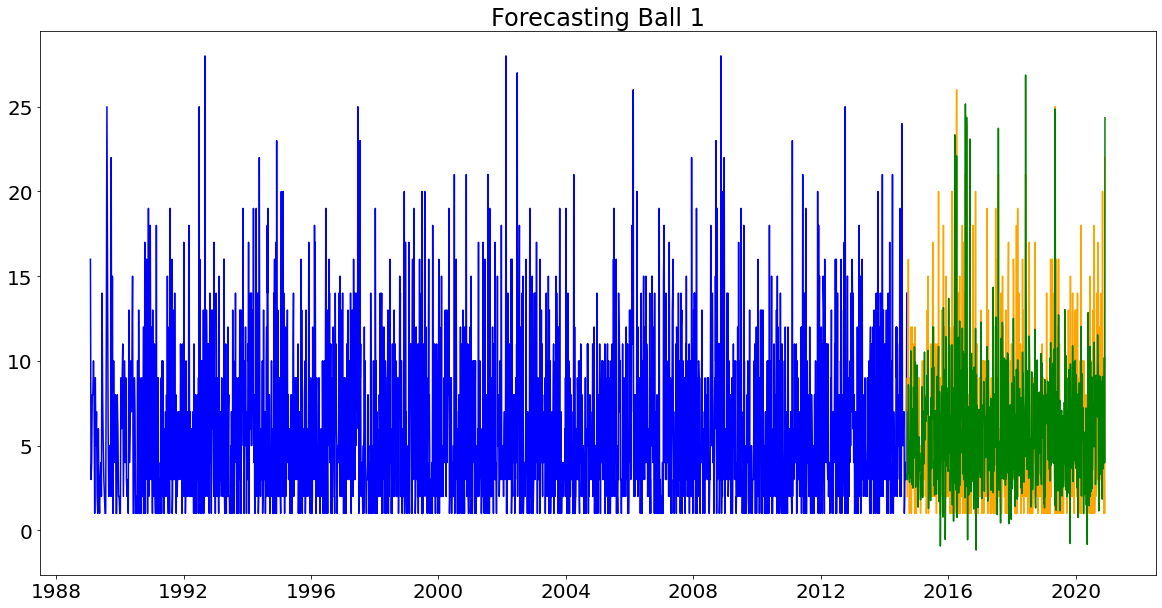

In [58]:
plt.figure(figsize=(20,10))

plt.plot(y_train.index, y_train.values, color = 'blue')

plt.plot(y_test.index, y_test.values, color = 'orange')

plt.plot(lm_results.predict(X_test), color = 'green')

plt.title(label = 'Forecasting Ball 1', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### VAR Time Series Model

In [59]:
df4 = df2[['ball_1_int','ball_2_int','ball_3_int','ball_4_int','ball_5_int','ball_6_int']]
df4.head()

,ball_1_int,ball_2_int,ball_3_int,ball_4_int,ball_5_int,ball_6_int
draw_date,,,,,,
1989-01-28,16,22,28,30,31,40
1989-02-04,3,11,29,30,39,40
1989-02-11,4,12,27,30,34,39
1989-02-18,8,17,19,31,33,39
1989-02-25,8,9,24,25,26,28


In [60]:
from statsmodels.tsa.stattools import adfuller

In [61]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [62]:
interpret_dftest(adfuller(df3['ball_1_int']))

Test Statistic   -28.241315
p-value            0.000000
Lag Used           3.000000
dtype: float64

In [63]:
interpret_dftest(adfuller(df3['ball_1_int'].diff(1).dropna()))

Test Statistic   -19.514764
p-value            0.000000
Lag Used          24.000000
dtype: float64

In [64]:
df3['diff_ball1'] = df3['ball_1_int'].diff(1)
df3['diff_ball2'] = df3['ball_2_int'].diff(1)
df3['diff_ball3'] = df3['ball_3_int'].diff(1)
df3['diff_ball4'] = df3['ball_4_int'].diff(1)
df3['diff_ball5'] = df3['ball_5_int'].diff(1)
df3['diff_ball6'] = df3['ball_6_int'].diff(1)

<ipython-input-64-5317d2cb292d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['diff_ball1'] = df3['ball_1_int'].diff(1)
<ipython-input-64-5317d2cb292d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['diff_ball2'] = df3['ball_2_int'].diff(1)
<ipython-input-64-5317d2cb292d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [65]:
ball_df = df3[['diff_ball1', 'diff_ball2', 'diff_ball3', 'diff_ball4', 'diff_ball5','diff_ball6']]
ball_df.dropna(inplace = True)

<ipython-input-65-a40322a9a3d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_df.dropna(inplace = True)


In [66]:
train, test = train_test_split(ball_df,
                               test_size = 0.25,
                               shuffle = False)

In [67]:
model = VAR(train)

/Users/taracelesta/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [68]:
ts_model = model.fit(maxlags=15, 
                     ic='aic')

In [69]:
ts_model.k_ar

15

In [70]:
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Dec, 2020
Time:                     07:26:47
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    19.7747
Nobs:                     2413.00    HQIC:                   18.9412
Log likelihood:          -42275.2    FPE:                1.04538e+08
AIC:                      18.4648    Det(Omega_mle):     8.37163e+07
--------------------------------------------------------------------
Results for equation diff_ball1
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.001779         0.098035           -0.018           0.986
L1.diff_ball1         -0.917460         0.026398          -34.755           0.000
L1.diff_ball2          0.001894         0.026307   

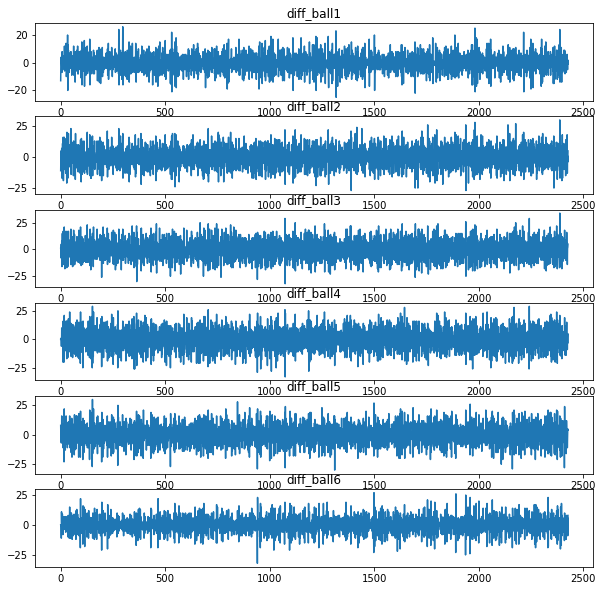

In [71]:
ts_model.plot();

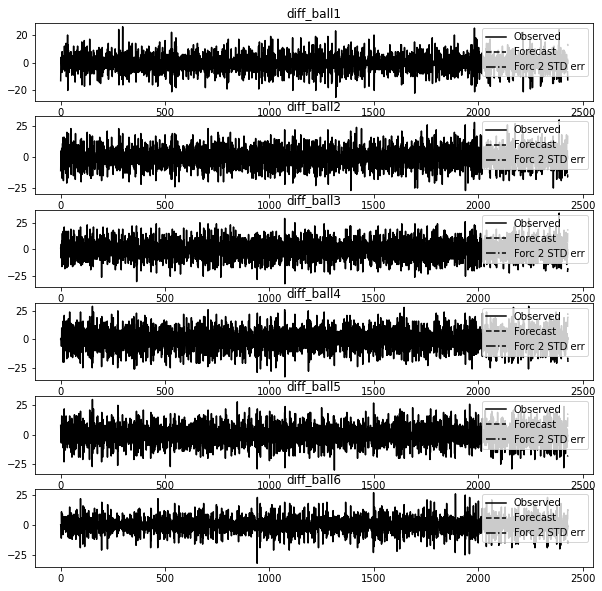

In [72]:
ts_model.plot_forecast(3);

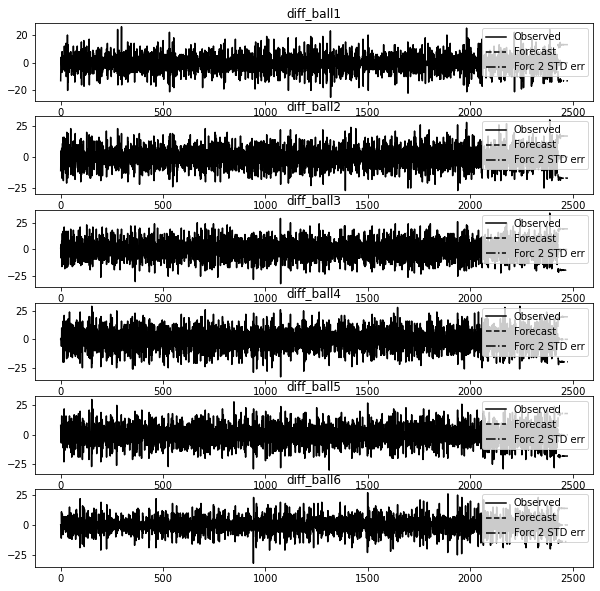

In [73]:
ts_model.plot_forecast(50);

In [74]:
ts_model.forecast(train.values, 1)

array([[ 3.43465321, -1.63967699, -7.35980058, -3.04929546, -5.91742382,
        -4.93319302]])

In [75]:
ts_model.forecast(train.values, 5)

array([[ 3.43465321, -1.63967699, -7.35980058, -3.04929546, -5.91742382,
        -4.93319302],
       [ 0.36290349,  0.4189702 ,  0.99480535,  2.93530628, -0.02272516,
         0.38479663],
       [-0.78994405,  0.26052897,  0.29366681, -0.4404213 ,  0.22141403,
        -1.66583295],
       [ 0.21748111, -1.99094886, -2.3176531 , -2.73860018, -1.12208438,
         0.61448717],
       [-2.12231792, -0.57036801,  0.50574891,  0.05877574,  0.9127506 ,
        -1.2139299 ]])

In [76]:
forecast = ts_model.forecast(train.values, len(test))

In [77]:
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the diff_ball1 data is: 49.0948
The test MSE on the diff_ball2 data is: 71.9387
The test MSE on the diff_ball3 data is: 95.2724
The test MSE on the diff_ball4 data is: 97.8041
The test MSE on the diff_ball5 data is: 86.4677
The test MSE on the diff_ball6 data is: 52.6506


## Naive Bayes: Ball 1 Prediction

In [78]:
X = df[['ball_2_int','ball_3_int','ball_4_int','ball_5_int','ball_6_int']]
y = df['ball_1_int']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [80]:
pipe = Pipeline([
    ('mnb', MultinomialNB())
])

In [81]:
pipe_params = {
    'mnb__alpha': np.linspace(0.5, 1.5, 6),
    'mnb__fit_prior': [True, False],
}

In [82]:
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [83]:
gs.fit(X_train, y_train)

/Users/taracelesta/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5, estimator=Pipeline(steps=[('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                         'mnb__fit_prior': [True, False]})

In [84]:
gs.best_score_

0.15232531500572738

In [85]:
gs.score(X_test, y_test)

0.14074074074074075

In [86]:
gs.best_params_

{'mnb__alpha': 1.1, 'mnb__fit_prior': True}

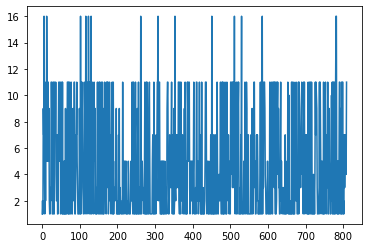

In [87]:
preds = gs.predict(X_test)

plt.plot(preds)
plt.show()

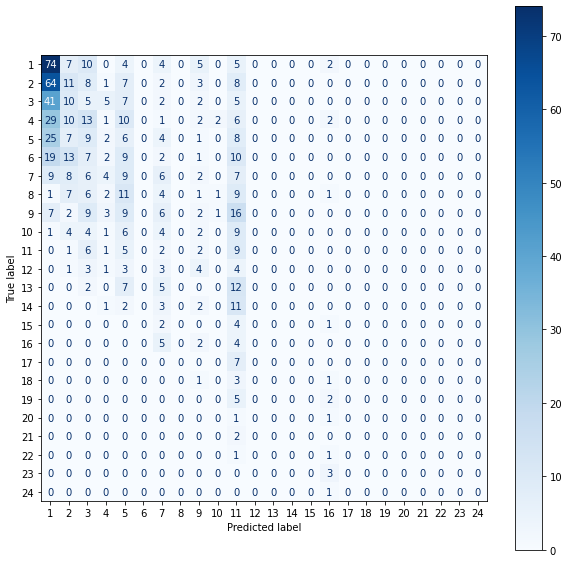

In [88]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d',ax=ax);

# Multilabel Classification
https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

In [89]:
#predicting groups based on numbers
X = df[['ball_1_int','ball_2_int','ball_3_int','ball_4_int','ball_5_int','ball_6_int']]
y = df[['odd_even_0','odd_even_1','odd_even_2','odd_even_3','odd_even_4','odd_even_5','odd_even_6',
        'high_low_0','high_low_1','high_low_2','high_low_3','high_low_4','high_low_5','high_low_6',
        'IQR_0','IQR_1','IQR_2','IQR_3','IQR_4','IQR_5','IQR_6',]]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [91]:
classifier = BinaryRelevance(GaussianNB())

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.0

In [92]:
classifier = LabelPowerset(GaussianNB())

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.13333333333333333

## Keras : Lotto Numbers as Integers

In [93]:
df.head()

,draw_date,draw_year,draw_month,draw_day,winning_numbers_list,winning_numbers,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6,ball_1_int,ball_2_int,ball_3_int,ball_4_int,ball_5_int,ball_6_int,odd_even,odd_even_0,odd_even_1,odd_even_2,odd_even_3,odd_even_4,odd_even_5,odd_even_6,high_low,high_low_0,high_low_1,high_low_2,high_low_3,high_low_4,high_low_5,high_low_6,IQR,IQR_0,IQR_1,IQR_2,IQR_3,IQR_4,IQR_5,IQR_6,delta_1,delta_2,delta_3,delta_4,delta_5,jackpot,jackpot_cash_value,jackpot_co_winners,match_5_prize,match_5_co_winners,match_4_prize,match_4_co_winners,match_3_prize,match_3_co_winners,match_5_2x_prize,match_5_2x_winners,match_5_3x_prize,match_5_3x_winners,match_5_4x_prize,match_5_4x_winners,match_5_5x_prize,match_5_5x_winners,match_4_2x_prize,match_4_2x_winners,match_4_3x_prize,match_4_3x_winners,match_4_4x_prize,match_4_4x_winners,match_4_5x_prize,match_4_5x_winners,match_3_2x_prize,match_3_2x_winners,match_3_3x_prize,match_3_3x_winners,match_3_4x_prize,match_3_4x_winners,match_3_5x_prize,match_3_5x_winners
0,2020-12-02,2020,12,02,[22 27 28 29 33 36],22 27 28 29 33 36,22,27,28,29,33,36,22,27,28,29,33,36,3,0,0,0,1,0,0,0,6,0,0,0,0,0,0,1,2,0,0,1,0,0,0,0,5,1,1,4,3,11085298.0,5542649.0,0,0,0,0,0,0,0,500,6,750,4,1000,1,1250,1,50,293,75,165,100,63,125,63,6,4468,9,2746,12,913,15,903
1,2020-11-28,2020,11,28,[1 5 23 25 29 40],1 5 23 25 29 40,1,5,23,25,29,40,1,5,23,25,29,40,5,0,0,0,0,0,1,0,4,0,0,0,0,1,0,0,3,0,0,0,1,0,0,0,4,18,2,4,11,10781834.0,5390917.0,0,0,0,0,0,0,0,500,7,750,4,1000,2,1250,1,50,289,75,185,100,60,125,71,6,4534,9,2690,12,878,15,984
2,2020-11-25,2020,11,25,[3 21 22 23 30 37],3 21 22 23 30 37,3,21,22,23,30,37,3,21,22,23,30,37,4,0,0,0,0,1,0,0,5,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,18,1,1,7,7,10500925.0,5250462.0,0,0,0,0,0,0,0,500,8,750,3,1000,1,1250,1,50,328,75,177,100,71,125,74,6,4610,9,2825,12,931,15,910
3,2020-11-21,2020,11,21,[1 13 18 25 37 40],1 13 18 25 37 40,1,13,18,25,37,40,1,13,18,25,37,40,4,0,0,0,0,1,0,0,3,0,0,0,1,0,0,0,3,0,0,0,1,0,0,0,12,5,7,12,3,10193214.0,5096607.0,0,0,0,0,0,0,0,500,3,750,4,1000,1,1250,1,50,338,75,177,100,69,125,63,6,4533,9,2765,12,907,15,876
4,2020-11-18,2020,11,18,[4 7 9 14 15 18],4 7 9 14 15 18,4,7,9,14,15,18,4,7,9,14,15,18,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,1,0,0,0,3,2,5,1,3,9889874.0,4944937.0,0,0,0,0,0,0,0,500,11,750,3,1000,3,1250,1,50,344,75,192,100,66,125,68,6,4844,9,2821,12,895,15,966


In [94]:
data = df[['ball_1_int','ball_2_int','ball_3_int', 'ball_4_int', 'ball_5_int','ball_6_int']]

In [95]:
#code help from: https://github.com/filipp-g/lotto-predict

def _load_data(df, n_prev=100):
    docX, docY = [], []
    for i in range(len(df) - n_prev):
        docX.append(df.iloc[i:i + n_prev].values)
        docY.append(df.iloc[i + n_prev].values)
    alsX = np.array(docX)
    alsY = np.array(docY)
    return alsX, alsY

def train_test_split(df, test_size=0.2):
    num_train = round(len(df) * (1 - test_size))
    X_train, y_train = _load_data(df.iloc[0:num_train])
    X_test, y_test = _load_data(df.iloc[num_train:])
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(data)

In [96]:
model = Sequential()
model.add(LSTM(49, input_shape=(None, 6)))
model.add(Dense(6, input_dim=49))
model.compile(loss="mse", optimizer="adam")

In [97]:
hist = model.fit(X_train, y_train, batch_size=450, epochs=3, validation_split=0.05)

Epoch 1/3
6/6 [==============================] - 1s 213ms/step - loss: 563.3328 - val_loss: 578.4659
Epoch 2/3
6/6 [==============================] - 1s 143ms/step - loss: 548.9377 - val_loss: 564.4081
Epoch 3/3
6/6 [==============================] - 1s 141ms/step - loss: 534.5305 - val_loss: 549.0447


In [98]:
predicted = model.predict(X_test)
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
print(f"\nPredicted numbers: {np.around(rmse)}")


Predicted numbers: [ 8. 12. 19. 24. 30. 35.]


array([ 7.82159914, 11.79627703, 18.81477706, 24.09636168, 29.85222872,
       35.3418485 ])

## Conclusion

Every lottery ticket purchased has an equal probability of winning for that particular game. Each drawing is independent of the next therefore there is no relation between historical numbers and future numbers

Becasue of this, my goal of predicting the exact numbers from one-time events, comeing out of what is essentially a fully random process, is impossible to achieve.

We can only predict using statistical methods and modeling when the data has some repeating patterns, corrilation or some inherent order.

But it was still a fun to try!

#### References

https://towardsdatascience.com/understanding-mega-millions-lottery-using-python-simulation-d2b07d30a7cc

https://towardsdatascience.com/the-house-always-wins-monte-carlo-simulation-eb82787da2a3

https://towardsdatascience.com/probability-of-winning-the-lottery-9331080952c4

https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

http://www.use4.com/prove-it.html  

http://www.flalottery.com/exptkt/pwrball-odds.pdf

https://www.statschat.org.nz/2012/09/05/lotto-and-abstract-theory/ 

https://lotterycodex.com/how-to-win-the-lottery-mathematically/ 

https://en.wikipedia.org/wiki/Lottery_mathematics#:~:text=Lottery%20mathematics%20is%20used%20to,way%20and%20combinations%20without%20replacement. 

https://github.com/JeffMv/Lofea 
 
https://github.com/uranusdemilo/LottoProj/blob/master/lotto.py
